In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

In [300]:
class MLP(nn.Module):
    """
    Create a simple MLP
    """
    def __init__(
        self,
        input_size,
        layer_sizes,
        output_size=None,
        output_activation=torch.nn.Identity,
        activation=torch.nn.ReLU
    ):
        super(MLP, self).__init__()
        sizes = [input_size] + layer_sizes
        if output_size is not None:
            sizes.append(output_size)
        layers = []
        for i in range(len(sizes) - 1):
            if (i < len(sizes) - 2):
                act = activation
            else:
                act = output_activation
            layers += [torch.nn.Linear(sizes[i], sizes[i + 1]), act()]
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


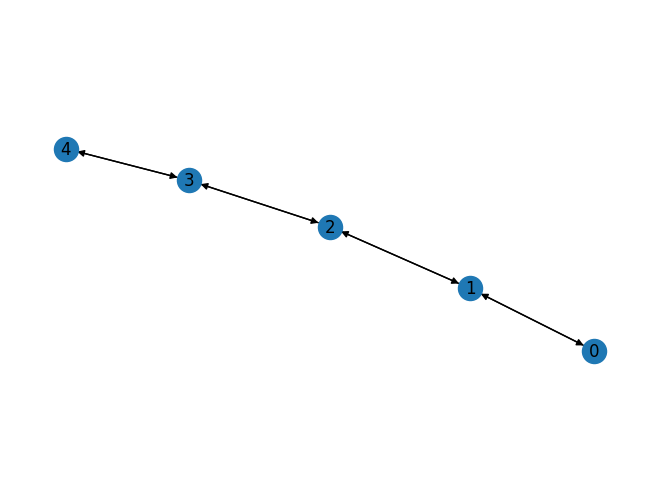

tensor([[0.5000, 0.0000],
        [1.5000, 0.0000],
        [2.5000, 0.0000],
        [3.5000, 0.0000],
        [4.5000, 0.0000]])


In [370]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph

def create_gnn_graph(coordinates, metadata):
    """
    Create a graph data object for a GNN model.

    Args:
    - coordinates (list of tuples): A list of 2D coordinates for each node.
    - E_initial (float): The initial value for the edge attribute.

    Returns:
    - data (Data): A PyG Data object representing the graph.
    """

    # Convert coordinates to tensor
    pos = torch.tensor(coordinates, dtype=torch.float)
    
    # Add the load as a node attribute
    load = torch.rand(pos.size(0), 1) * metadata["P_initial"]

    # Create edges
    num_nodes = len(coordinates)
    edge_index = radius_graph(pos, r=metadata["default_connectivity_radius"], loop=False)

    # Calculate edge attributes (e.g., Euclidean distance)
    distance = torch.norm(pos[edge_index[0]] - pos[edge_index[1]], dim=1).unsqueeze(1)
    # Calculate displacement as vector at each edge
    displacement = (pos[edge_index[1]] - pos[edge_index[0]])   
    
    # Convert E_initial to a PyTorch tensor
    E_initial = torch.tensor(metadata["E_initial"], dtype=torch.float)
    # Correctly generate a tensor with random values uniformly distributed between 0 and 1, then scale by E_initial
    E_edge = torch.rand(edge_index.size(1), 1) * E_initial

    # Now, both tensors have shape [number_of_edges, 1] and can be concatenated
    edge_attr = torch.cat([distance, displacement, E_edge], dim=1)

    # Concat node features and load
    node_features = torch.cat([pos], dim=1)
    
    # Create a graph data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    
    return data

# Example usage
metadata = {"default_connectivity_radius": 1.6, "E_initial": 10, "P_initial": 0.5,
"node_features": ["x", "y", "load"], "edge_features": ["distance", "displacement", "E_edge"],
"node_input_size": 2, "edge_input_size": 4}
coordinates = [(0.5, 0), (1.5, 0), (2.5, 0), (3.5, 0), (4.5, 0)]
graph_data = create_gnn_graph(coordinates, metadata)

graph = to_networkx(graph_data)
nx.draw(graph, with_labels=True)
plt.show()

print(graph_data.x)

In [371]:
# Import data
import pandas as pd

df = pd.read_json(r"C:\Users\kurt-\Documents\GitHub\dsa-2024\data\JSON_Data_Updated\n=100_p=1_varying_l_vectors.json")

In [372]:
np.array(df[1][0][0]) - np.array(df[1][0][1])

array([-0.1010101,  0.       ])

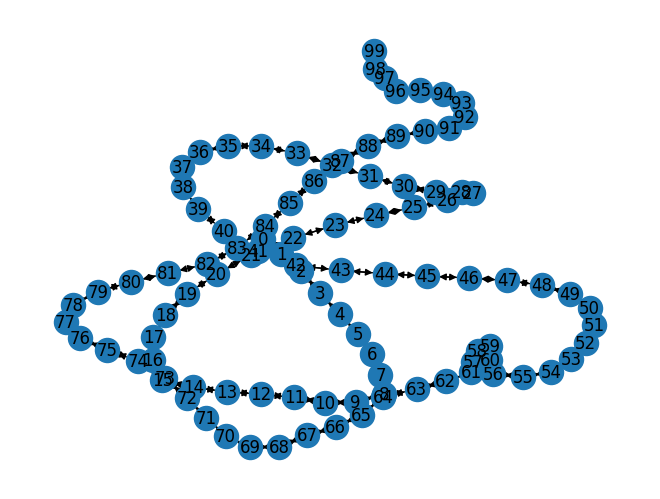

In [373]:
# Example usage with beam data

metadata["default_connectivity_radius"] = 0.1011
metadata["E_initial"] = 10
metadata["P_initial"] = 0.5

A  = create_gnn_graph(df[1][0], metadata)

graph = to_networkx(A)
nx.draw(graph, with_labels=True)
plt.show()

In [374]:
# Encoder
import torch
import torch.nn as nn
class Encoder(torch.nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, mlp_num_layers, mlp_hidden_dim,):
        super().__init__()
        self.node_fn = nn.Sequential(*[MLP(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], node_out), nn.LayerNorm(node_out)])
        self.edge_fn = nn.Sequential(*[MLP(edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], edge_out), nn.LayerNorm(node_out)])

    def reset_parameters(self):
        self.mlp.reset_parameters()

    def forward(self, node_pos, edge_index, edge_attr):
        return self.node_fn(node_pos), self.edge_fn(edge_attr)


In [375]:
# Decoder
class Decoder(torch.nn.Module):
    def __init__(self, node_in, edge_in, mlp_num_layers, mlp_hidden_dim):
        super().__init__()
        # No LayerNorm in the decoder
        self.node_fn = nn.Sequential(*[MLP(node_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], 2)]) # Predicting load and displacement
        self.edge_fn = nn.Sequential(*[MLP(edge_in, [mlp_hidden_dim for _ in range(mlp_num_layers)], 1)]) # Predicting E_edge

    def reset_parameters(self):
        self.mlp.reset_parameters()

    def forward(self, node_pos, edge_attr):
        out_node = self.node_fn(node_pos)
        out_edge = self.edge_fn(edge_attr)
        return out_node, out_edge

In [376]:
print(A.x.shape, A.edge_attr.shape)

torch.Size([100, 2]) torch.Size([198, 4])


In [377]:
node_in = metadata["node_input_size"]
node_out = 5
edge_in = metadata["edge_input_size"]
edge_out = 5
out_hidden_dim = 10
out_num_layers = 4
out_size = 1

mlp_num_layers = 4
mlp_hidden_dim = 10

encoder = Encoder(node_in, node_out, edge_in, edge_out, mlp_num_layers, mlp_hidden_dim)
out1, out2 = encoder.forward(A.x, A.edge_index, A.edge_attr)
decoder = Decoder(node_out, edge_out, mlp_num_layers, mlp_hidden_dim)
out3, out4 = decoder.forward(out1, out2)


In [378]:
# Create a training process for the model

class BeamNN(nn.Module):
    def __init__(self, node_in, node_out, edge_in, edge_out, mlp_num_layers, mlp_hidden_dim):
        super(BeamNN, self).__init__()
        self.encoder = Encoder(node_in, node_out, edge_in, edge_out, mlp_num_layers, mlp_hidden_dim)
        self.decoder = Decoder(node_out, edge_out, mlp_num_layers, mlp_hidden_dim)

    def forward(self, node_pos, edge_index, edge_attr):
        node_out, edge_out = self.encoder(node_pos, edge_index, edge_attr)
        node_out, edge_out = self.decoder(node_out, edge_out)
        return node_out, edge_out

    def reset_parameters(self):
        self.encoder.reset_parameters()
        self.decoder.reset_parameters()



In [379]:
# Separate input and output
df_input = df[1]
df_output = df[[0,2]]

In [387]:
# Assuming 'df' is a pandas DataFrame and you want to create a PyTorch Geometric Dataset from it
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

class BeamDataset(Dataset):
    def __init__(self, df_input, transform=None):
        super().__init__()
        self.input = df_input
        self.transform = transform

    def len(self):
        return len(self.input)

    def get(self, idx):
        # Extract node features, edge indices, edge attributes from self.df
        graph_data = create_gnn_graph(self.input[idx], metadata)
        node_features = graph_data.x
        edge_index = graph_data.edge_index
        edge_attr = graph_data.edge_attr
        # Create and return a PyTorch Geometric Data object
        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
        if self.transform:
            self.data = self.transform(data)
        return data

# Create a PyTorch Geometric Dataset from your DataFrame
dataset = BeamDataset(df_input)

# Modify the DataLoader to use the Dataset
data_loader = DataLoader(dataset, batch_size=1)

In [391]:
model = BeamNN(node_in, node_out, edge_in, edge_out, mlp_num_layers, mlp_hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
#

A = dataset[0]
out = model(A.x, A.edge_index, A.edge_attr)

In [359]:
# Train
import torch.optim as optim

# Use tqdm for progress bar
from tqdm import tqdm


# Initialize the model
model = BeamNN(node_in, node_out, edge_in, edge_out, mlp_num_layers, mlp_hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Define loss
def loss_PDE(x, out_pred, E_pred):
    x.requires_grad = True
    u_x = torch.autograd.grad(out, x, grad_outputs=torch.ones_like(out), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(out), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(out), create_graph=True)[0]
    u_x4 = torch.autograd.grad(u_xxx, x, grad_outputs=torch.ones_like(out), create_graph=True)[0]

    # Function to minimize
    f = E_pred * u_x4 - out_pred
    return u_x4





In [351]:
# Begin training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BeamNN(node_in, node_out, edge_in, edge_out, mlp_num_layers, mlp_hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
data_loader = DataLoader([A], batch_size=1, shuffle=True)

losses = []
for epoch in tqdm(range(100)):
    loss = train(model, data_loader, optimizer, criterion, device)
    losses.append(loss)
    print(f"Epoch {epoch}, Loss: {loss:.4f}")

plt.plot(losses)

C:\Users\kurt-\AppData\Roaming\Python\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\kurt-\miniconda3\envs\ML\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([100, 3])) that is different to the input size (torch.Size([100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 1

In [ ]:
# Start training
losses = []
for epoch in range(100):
    loss = train(model, data_loader, optimizer, criterion, device)
    print(f'Epoch {epoch}, Loss: {loss}')
    losses.append(loss)

plt.plot(losses)